In [24]:
%load_ext autoreload
%autoreload 2

import wandb
import torch
from einops import rearrange
from text3d2video.multiview_features_artifact import MVFeaturesArtifact
from text3d2video.wandb_util import first_used_artifact_of_type
from text3d2video.animation_artifact import AnimationArtifact
from matplotlib import pyplot as plt
from text3d2video.visualization import RgbPcaUtil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
api = wandb.Api()

mv_features = 'deadpool_mv_features:latest'
mv_features = api.artifact(f'romeu/diffusion-3D-features/{mv_features}')
mv_features = MVFeaturesArtifact.from_wandb_artifact(mv_features)

mv_featuers_run = mv_features.wandb_artifact.logged_by()
animation = first_used_artifact_of_type(mv_featuers_run, AnimationArtifact.artifact_type)
animation = AnimationArtifact.from_wandb_artifact(animation)
mesh = animation.load_static_mesh()

wandb: Downloading large artifact deadpool_mv_features:latest, 5167.76MB. 118 files... 
wandb:   118 of 118 files downloaded.  
Done. 0:0:3.9
wandb: Downloading large artifact backflip:v1, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.3


In [26]:
features_path = mv_features.get_features_path()
files = list(features_path.iterdir())

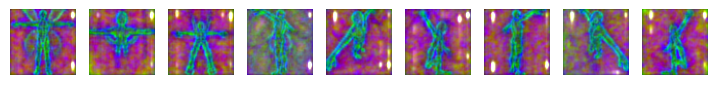

In [33]:
feature_id = {'layer':'level_2', 'timestep': 10}
features = [mv_features.get_feature(i, feature_id) for i in mv_features.view_indices()]

all_features = torch.stack(features)

all_features = rearrange(all_features, 'v c h w -> (v h w) c')
pca = RgbPcaUtil(all_features.shape[1])
pca.fit(all_features)

features_rgb = [pca.feature_map_to_rgb(feature) for feature in features]

cams = mv_features.get_cameras()

N = len(features_rgb)
scale = 1
fig, axs = plt.subplots(1, N, figsize=(scale*N, scale))
for i in range(N):
    axs[i].imshow(features_rgb[i].permute(1,2,0))
    axs[i].axis('off')